In [59]:
import numpy as np
import matplotlib.pyplot as plt

Utilizaremos los siguientes generadores de números uniformes:
- `Lineal congruential generator (LCG)`
- `XORShift (64 bits)`
- `Mersenne Twister (MT19937)`

In [60]:
class LCG:
    def __init__(self, seed):
        self.state = seed
        self.a = 16807
        self.m = 2**31 - 1
        self.c = 0
    
    def random(self):
        self.state = (self.state * self.a + self.c) % self.m
        return self.state / self.m # Normalize to [0, 1)

In [61]:
class Xorshift64:
    def __init__(self, seed):
        if seed == 0:
            raise ValueError("Seed must be non-zero")
        self.state = seed % (2**64)   
         
    def random(self):
        x = self.state
        # Apply the mask after each operation to keep it within 64-bit range
        x = (x ^ (x << 13)) & 0xFFFFFFFFFFFFFFFF
        x = (x ^ (x >> 7)) & 0xFFFFFFFFFFFFFFFF
        x = (x ^ (x << 17)) & 0xFFFFFFFFFFFFFFFF
        self.state = x
        
        return self.state / (2**64) # Normalize to [0, 1)

In [62]:
def MT19937(seed):
    """
    Mersenne Twister (MT19937) to generate a pseudo-random variable.  
    Returns a Generator object.
    """
    return np.random.Generator(bit_generator=np.random.MT19937(seed))

In [63]:
class RNG:
    """
    Random Number Generator (RNG)
    Use this class to generate a random number using some of the available generators:
    - xorshift64
    - mt19937
    - lcg
    The default algorithm is xorshift64.
    You can also pass a seed to the RNG. If no seed is provided, the current time in nanoseconds is used as the seed.
    The seed must be non-zero for xorshift64 and lcg algorithms.
    
    Usage:
    Without passing seed:
    r = RNG("xorshift64")
    r.random()
    
    Passing seed:
    r = RNG("xorshift64", seed=1234)
    r.random()
    """
    def __init__(self, algo='xorshift64', seed=None):
        if seed is None:
            seed = 1234
        
        self.algo = algo.lower()
        
        if self.algo == 'xorshift64':
            if seed == 0:
                raise ValueError("Seed must be non-zero for Xorshift64")
            self.generator = Xorshift64(seed)
        elif self.algo == 'mt19937':
            self.generator = MT19937(seed)
        elif self.algo == 'lcg':
            self.generator = LCG(seed)
        else:
            raise ValueError(f"Unknown algorithm: {self.algo}")
    
    def random(self):
        return self.generator.random()

#### Intensidad del proceso Poisson homogéneo
$$
    \lambda(t) = 30 + 30 \cdot \sin\left(\frac{2\pi t}{24}\right) \text{ (clientes/hora)}
$$

In [64]:
# Intensidad del Poisson proceso homogéneo
def lambda_t(t):
    """
    Intensity function for a homogeneous Poisson process.
    """
    return 30 + 30 * np.sin((2*np.pi*t)/24)


#### Tiempo de Atención

Corresponde a una distribución exponencial con tasa $ \mu = 40 $ (clientes / hora).  
Para calcular el tiempo de atención usamos la transformada inversa:
$$
    T = -\frac{1}{40} \ln{U}
$$

In [65]:
def service_time(gen: RNG):
    u = gen.random()
    return -np.log(u) / 40

#### Servidor

El servidor se encarga de procesar la lista de eventos t_arrivals.  
La función devuelve metricas sobre el uso y evolución del sistema a lo largo del tiempo:

- **Tiempo promedio en el sistema por cliente:**  
    $ \text{t\_end\_service}[i] - \text{t\_arrivals}[i] $
- **Tiempo de espera promedio en la cola:**  
    $ \text{t\_start\_service}[i] - \text{t\_arrivals}[i] $
- **Tiempo promedio de servicio:**  
    $ \text{t\_end\_service}[i] - \text{t\_start\_service}[i] $
- **Registro de variación de longitud de la cola a lo largo del tiempo:**  
    $ \text{events\_queue} $

In [66]:
from queuelib.queue import FifoMemoryQueue as Queue

def server(t_arrivals: list, gen: RNG):
    """
    Handles a list of users and returns metrics about its usage.  
    
    Parameters:
    - **t_arrivals**: List of events
    - **gen**: An object of type RNG
    """
    t_server_available = 0
    wait_queue = Queue()
    
    # metrics
    t_start_service = []
    t_end_service = []
    events_queue = []
    
    # process all events
    for t_curr, t_next in zip(t_arrivals, t_arrivals[1:]):
        t_arrival = t_curr
        
        if t_arrival >= t_server_available:
            # server is available
            t_start = t_arrival
            t_service = service_time(gen)
            t_end = t_start + t_service
            
            t_server_available = t_end
            
            # metrics
            t_start_service.append(t_start)
            t_end_service.append(t_end)
            events_queue.append((t_arrival, len(wait_queue)))
            events_queue.append((t_end, len(wait_queue)))

            # process events on queue
            while len(wait_queue) and t_server_available <= t_next:
                wait_queue.pop()
                t_start = t_server_available
                t_service = service_time(gen)
                t_end = t_start + t_service
            
                t_server_available = t_end
                
                # metrics
                t_start_service.append(t_start)
                t_end_service.append(t_end)
                events_queue.append((t_arrival, len(wait_queue)))
                events_queue.append((t_end, len(wait_queue)))
                
        else:
            # server is unavailable
            wait_queue.push(t_curr)
            
            #metrics
            events_queue.append((t_arrival, len(wait_queue)))

    return np.array(t_start_service), np.array(t_end_service), np.array(events_queue)

#### Generación de eventos

Generamos eventos con $ t \ \epsilon \ [0, \ T\_max] $.  
La variable `lambda_max` corresponde al máximo valor posible de la función `lambda_t` que es 60.
La generación de candidatos se basa en:  
1. Generamos el candidato `u1` y lo sumamos al tiempo transcurrido usando el método de la transformada inversa.
2. Si todavía no superamos la cota superior `T_max`, generamos `u2`.
3. Decidimos si `t` es un valor razonable para este momento usando la relación $ u2 \lt \frac{\lambda(t)}{60} $ que corresponde a la probabilidad de que se dé lo mencionado.
4. Aceptamos `t` y lo agregamos a la lista o seguimos con la siguiente iteración.

In [67]:
def events_generator(gen: RNG) -> list:
    t = 0
    arrivals = []
    T_max = 48
    lambda_max = 60
    
    while True:
        # Generate an interarrival time candidate
        u1 = gen.random()
        
        # Fix the log(0) issue by ensuring u1 is never exactly 1
        if u1 >= 1.0:
            u1 = 1.0 - 1e-15  # Very small epsilon to avoid log(0)
        
        t += -np.log(1 - u1) / lambda_max
        
        # Terminate if generated time is bigger than T_max bound
        if t > T_max:
            break
        
        # Decide if t is accepted based on lambda(t) / lambda_max relation
        u2 = gen.random()
        if u2 < lambda_t(t) / lambda_max:
            arrivals.append(t)
    
    return np.array(arrivals)


Simulamos durante 48 horas, con los 3 generadores de números aleatorios mencionados.
Simularemos 1_000 veces con distintas semillas para cada generador y luego tomaremos el promedio de las métricas obtenidas.

- **Tiempo promedio en el sistema por cliente:**  
    Para el calculo del tiempo promedio en el sistema por cliente, usamos la diferencia entre el tiempo de finalización del servicio y el tiempo de llegada del cliente. Es importante considerar que este tiempo incluye tanto el tiempo de espera en la cola como el tiempo de servicio y no se tienen en cuenta aquellos clientes que no llegaron a ser atendidos.

    $ \text{t\_end\_service}[i] - \text{t\_arrivals}[i] $
- **Tiempo de espera promedio en la cola:**  
    Para calcular el tiempo de espera promedio en la cola, restamos el tiempo de llegada del cliente al tiempo en que comienza su servicio. Este valor nos da una idea del tiempo que un cliente pasa esperando antes de ser atendido.

    $ \text{t\_start\_service}[i] - \text{t\_arrivals}[i] $
- **Tiempo promedio de servicio:**  
    Para calcular el tiempo promedio de servicio, restamos el tiempo en que comienza el servicio del tiempo en que finaliza. Este valor nos indica cuánto tiempo tarda un cliente en ser atendido una vez que comienza su servicio.
    
    $ \text{t\_end\_service}[i] - \text{t\_start\_service}[i] $
- **Registro de variación de longitud de la cola a lo largo del tiempo:**  
    Para las colas, registramos el maximo largo de la cola en cada hora de las 48hs simuladas. 

    $ \text{events\_queue} $

In [68]:
def run_simulations(gen_name: str, start_seed=1):
    all_t_arrivals = []
    all_t_starts = []
    all_t_ends = []
    queues = []
    
    for i in range(1000):
        seed = start_seed + i
        gen = RNG(gen_name, seed)
        t_arrivals = events_generator(gen)
        t_start_service, t_end_service, events_queue = server(t_arrivals, gen)
        
        all_t_arrivals.append(t_arrivals)
        all_t_starts.append(t_start_service)
        all_t_ends.append(t_end_service)
        
        if i == 0:  # only keep one to graph the evolution
            queues = events_queue
        
    return all_t_arrivals, all_t_starts, all_t_ends, queues


generadores = ["xorshift64", "mt19937", "lcg"]
start_seeds = [1, 1001, 2001]

all_results = {}
all_queues = []

for gen_name, start_seed in zip(generadores, start_seeds):
    t_arrivals, t_starts, t_ends, queue = run_simulations(gen_name, start_seed)
    all_results[gen_name] = {
        "t_arrival": t_arrivals,
        "t_start": t_starts,
        "t_end": t_ends,
    }
    all_queues.append(queue)

### Gráficos

In [69]:
colors = ["red", "blue", "green"]

##### Tiempo promedio en el sistema por cliente

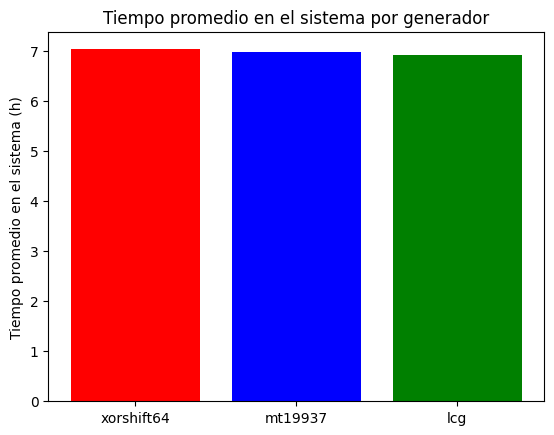

In [70]:
labels = []
avg_times = []

for gen_name, data in all_results.items():
    total_times = []
    for t_arrival, t_end in zip(data["t_arrival"], data["t_end"]):
        total_times.extend(np.array(t_end) - np.array(t_arrival[:len(t_end)]))
    avg_times.append(np.mean(total_times))
    labels.append(gen_name)

plt.bar(labels, avg_times, color=colors)
plt.ylabel("Tiempo promedio en el sistema (h)")
plt.title("Tiempo promedio en el sistema por generador")
plt.show()

##### Porcentaje de tiempo que el servidor está ocupado

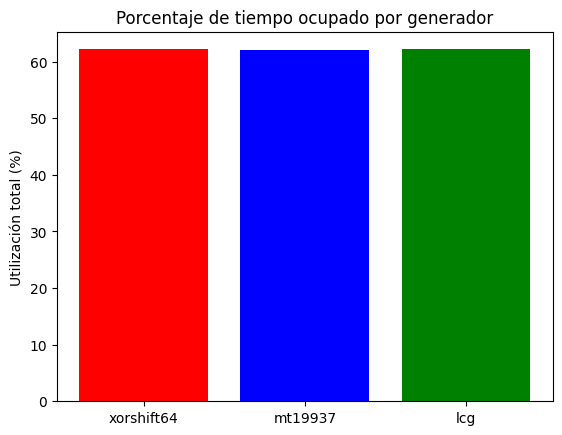

In [71]:
labels = []
percentages = []

for gen_name, data in all_results.items():
    total_busy_time = 0
    for t_start, t_end in zip(data["t_start"], data["t_end"]):
        total_busy_time += np.sum(np.array(t_end) - np.array(t_start[:len(t_end)]))
    total_sim_time = 48 * len(data["t_start"])
    utilization = total_busy_time / total_sim_time
    percentages.append(utilization * 100)
    labels.append(gen_name)

plt.bar(labels, percentages, color=colors)
plt.ylabel("Utilización total (%)")
plt.title("Porcentaje de tiempo ocupado por generador")
plt.show()

##### Histograma de los tiempos de espera en el sistema

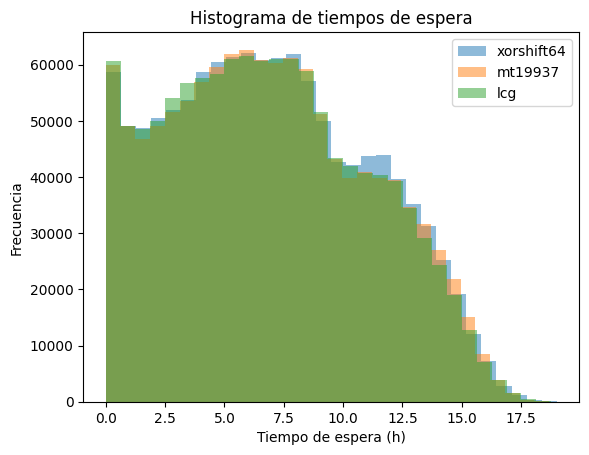

In [72]:
for gen_name, data in all_results.items():
    waits = []
    for t_arrival, t_start in zip(data["t_arrival"], data["t_start"]):
        waits.extend(np.array(t_start) - np.array(t_arrival[:len(t_start)]))
    plt.hist(waits, bins=30, alpha=0.5, label=gen_name)

plt.xlabel("Tiempo de espera (h)")
plt.ylabel("Frecuencia")
plt.title("Histograma de tiempos de espera")
plt.legend()
plt.show()

##### Evolución de la longitud de la cola en el tiempo

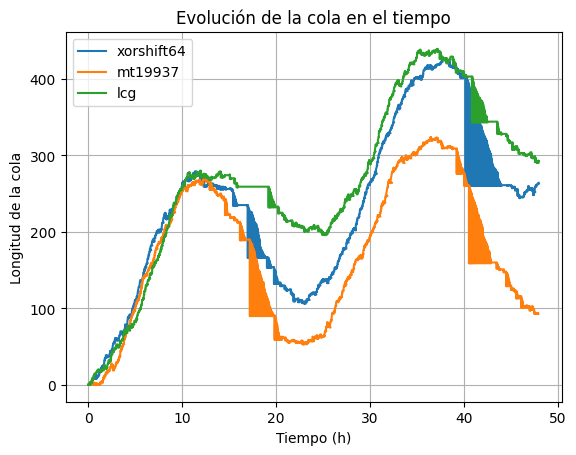

In [73]:
for queue, label in zip(all_queues, labels):
    times, lengths = zip(*queue)
    plt.plot(times, lengths, label=label)

plt.xlabel("Tiempo (h)")
plt.ylabel("Longitud de la cola")
plt.title("Evolución de la cola en el tiempo")
plt.legend()
plt.grid(True)
plt.show()

##### Tasa de utilización del servidor en función del tiempo

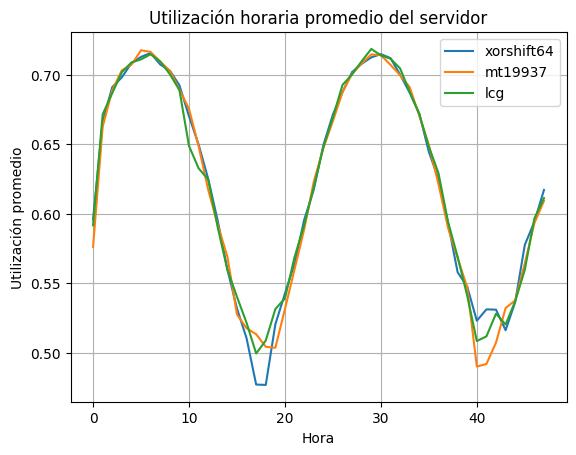

In [74]:
def server_utilization(t_start_service_list, t_end_service_list, T_MAX=48):
    utilization = np.zeros(T_MAX)

    for sim_starts, sim_ends in zip(t_start_service_list, t_end_service_list):
        for s, e in zip(sim_starts, sim_ends):
            for hour in range(int(np.floor(s)), int(np.ceil(e))):
                if 0 <= hour < T_MAX:
                    # how long it has been busy during this hour
                    overlap_start = max(s, hour)
                    overlap_end = min(e, hour + 1)
                    utilization[hour] += (overlap_end - overlap_start)

    # convert to proportion (divided by number of simulations and 1h)
    utilization /= len(t_start_service_list)

    return utilization


bins = np.arange(0, 48, 1)

for gen_name, data in all_results.items():
    avg_util = server_utilization(data["t_start"], data["t_end"])
    plt.plot(bins, avg_util, label=gen_name)

plt.xlabel("Hora")
plt.ylabel("Utilización promedio")
plt.title("Utilización horaria promedio del servidor")
plt.legend()
plt.grid(True)
plt.show()